<a href="https://colab.research.google.com/github/gamecicn/TF2_Study/blob/yt_tf2_tutorial/T2TE1_Predict_Stock_With_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ETF/510050Full.txt')
df.tail(5)

,data,open,high,low,close,volumn,money
3829,2020/11/19,3.424,3.468,3.420,3.460,411932902,1.421195e+09
3830,2020/11/20,3.462,3.468,3.445,3.465,352204402,1.217078e+09
3831,2020/11/23,3.472,3.540,3.471,3.521,756216358,2.653729e+09
3832,2020/11/24,3.521,3.529,3.491,3.493,723999385,2.537057e+09
3833,2020/11/25,3.505,3.525,3.467,3.468,595775601,2.082199e+09


In [ ]:
features_considered = ['open', 'high', 'low', 'volumn', 'close']

features = df[features_considered]
features.index = df['data']
features.head()

,open,high,low,volumn,close
data,,,,,
2005/02/23,0.881,0.882,0.866,1269742542,0.876
2005/02/24,0.876,0.876,0.868,451614223,0.876
2005/02/25,0.877,0.887,0.875,506460695,0.880
2005/02/28,0.878,0.879,0.870,187965193,0.872
2005/03/01,0.870,0.873,0.865,208094456,0.867


In [ ]:
features.shape

(3834, 5)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff53edc5198>,
      dtype=object)

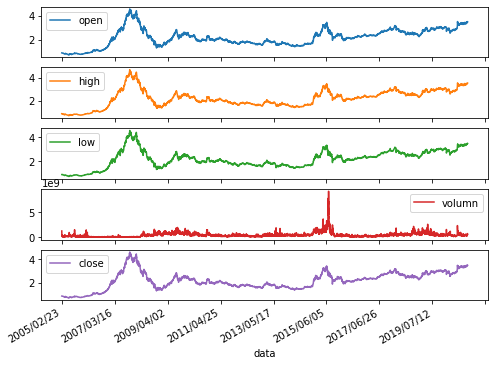

In [ ]:
features.plot(subplots=True)

## Standiazation 

In [ ]:
TRAIN_SPLIT = 3500

dataset = features.values

data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [ ]:
dataset

array([[-1.70942531, -1.71823383, -1.72605696,  1.54390147, -1.7190659 ],
       [-1.71649981, -1.72661026, -1.72318382, -0.051443  , -1.7190659 ],
       [-1.71508491, -1.71125346, -1.71312785,  0.05550724, -1.71340759],
       ...,
       [ 1.95658173,  1.99252698,  2.01619998,  0.54252902,  2.02249112],
       [ 2.02591185,  1.97717018,  2.04493131,  0.47970615,  1.98288296],
       [ 2.00327345,  1.97158589,  2.01045371,  0.22967068,  1.94751853]])

## Prepare Data

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      future_target, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - future_target

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)  
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+future_target]) 
        else:
            labels.append(target[i:i+future_target])

    return np.array(data), np.array(labels)

In [ ]:
past_history = 3
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, 
                                                   dataset[:, 1], 
                                                   0,
                                                   TRAIN_SPLIT, 
                                                   past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
x_train_single.shape

In [ ]:
y_train_single.shape

(1980,)

## 构建训练数据

In [ ]:
EPOCHS = 10

BATCH_SIZE = 64
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
train_data_single

<RepeatDataset shapes: ((None, 20, 5), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,  input_shape=x_train_single.shape[-2:]))  # return_sequences=True, 
#single_step_model.add(tf.keras.layers.LSTM(64))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

single_step_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 32)                4864      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(64, 1)


In [ ]:
EVALUATION_INTERVAL = 200

single_step_history = single_step_model.fit(train_data_single, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 3s 5ms/step - loss: 0.5166 - val_loss: 0.0874
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0882 - val_loss: 0.1154
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0567 - val_loss: 0.0563
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0611 - val_loss: 0.0420
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0478 - val_loss: 0.1456
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0495 - val_loss: 0.0491
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0474 - val_loss: 0.0416
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0417 - val_loss: 0.0380
Epoch 9/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0461 - val_loss: 0.0443
Epoch 10/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0416 - val_loss: 0.0363

In [ ]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

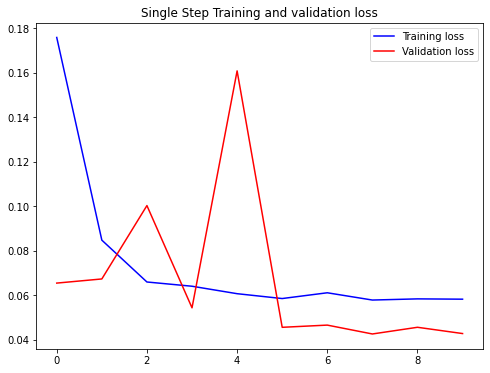

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

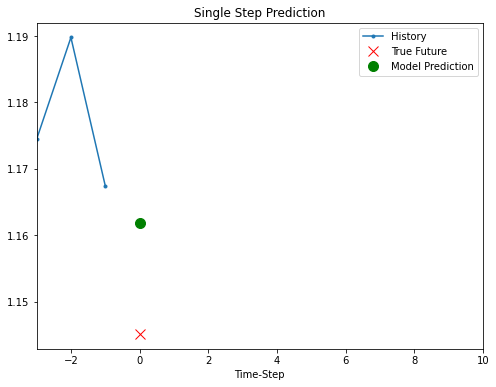

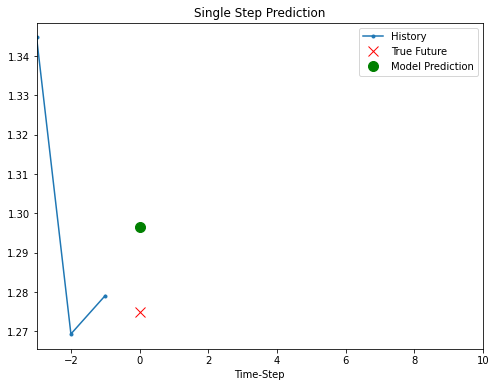

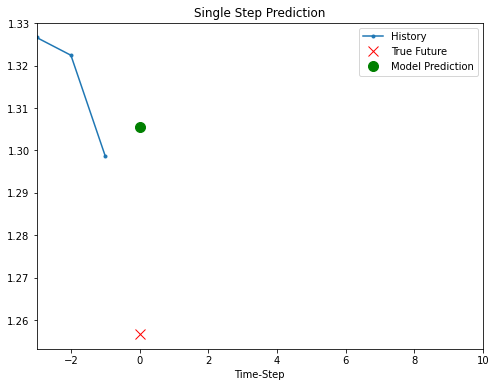

In [ ]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 0,
                   'Single Step Prediction')
    plot.show()